Damping coefficient a0 = 0.12441951103325914 ; a1 = 0.00078789575788067
Number vertical elements : 160
Vertical size of elements 0.25
horizontal size of element 0.25
Finished creating all nodes
Finished creating dashpot nodes
Finished creating all boundary conditions and equalDOF
Finished creating all soil material


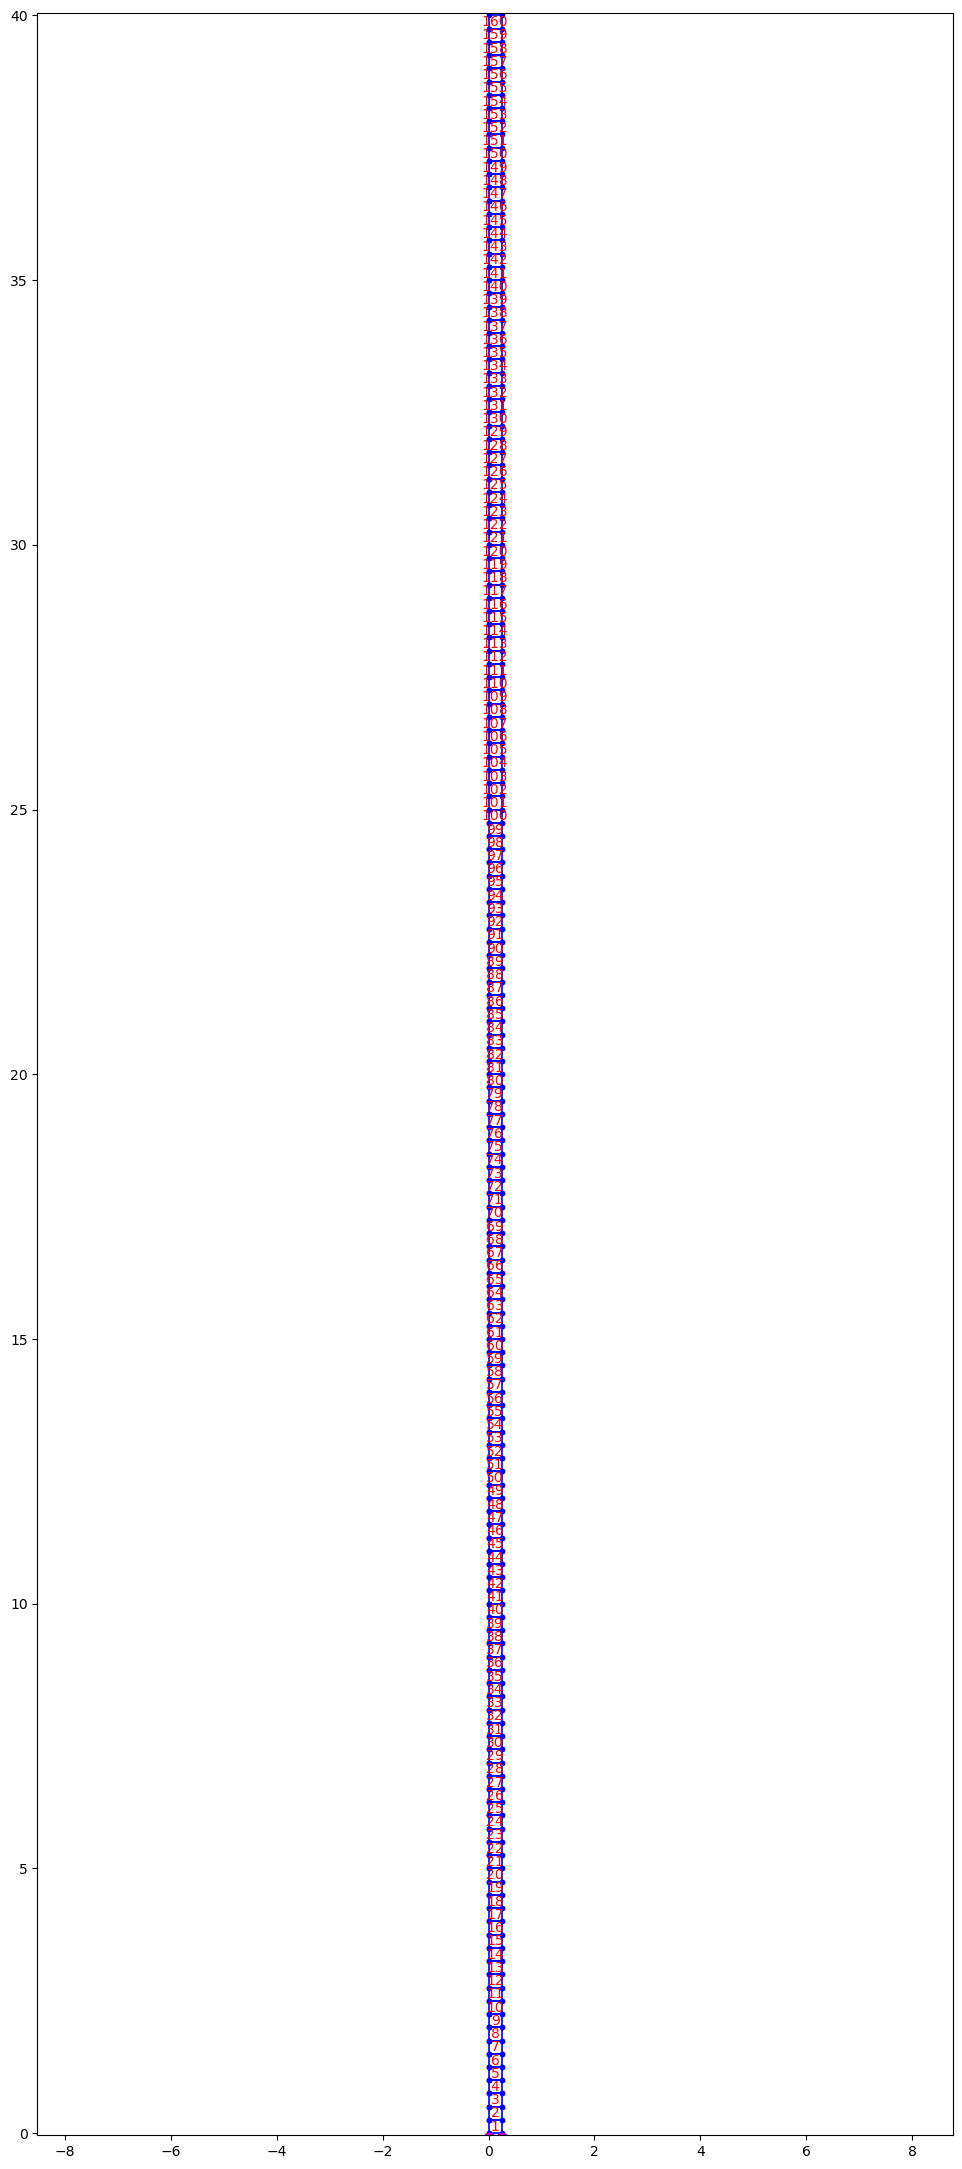

In [ ]:
# ------------------------------ Import Library ------------------------------ #
# Import OpenSeesPy for finite element analysis and OpsVis for visualization
import openseespy.opensees as ops  # Main OpenSeesPy module for FEM analysis
import opsvis as opsv  # Visualization tools for OpenSees models
from math import *  # Import all math functions
import numpy as np  # Numerical computing library
import matplotlib.pyplot as plt

# ----------------------------------- Wipe ----------------------------------- #
# Clear any existing OpenSees model to start fresh
ops.wipe()  # This removes any previous model definitions

# ----------------------- 1. DEFINE ANALYSIS PARAMETER ----------------------- #

# ------------------------------- Soil Geometry ------------------------------ #
# Total thickness of soil deposit (in meters)
soilThick = 40.0  # [m] Total depth of soil column being modeled

# ---------------------------- Material Properties --------------------------- #
# Mass density of soil (in megagrams per cubic meter)
rho = 1.7  # [Mg/m³] (equivalent to g/cm³, mass density of soil)

# Shear wave velocity of soil (in meters per second)
# Typical range for soft soil: 100-300 m/s
Vs = 250  # [m/s] Shear wave velocity of soil

# Calculate shear modulus (G) using formula: G = ρ * Vs²
# Units: Mg/m³ * (m/s)² = kN/m² (since 1 Mg·m/s² = 1 kN)
refShearModul = rho * Vs**2  # [kN/m²] Shear modulus of soil

# Poisson's ratio (dimensionless)
# nu=0.0 for simple shear deformation assumption
nu = 0.0  # [-] Poisson's ratio (0.0 for simple shear condition)

# Calculate Young's modulus (E) using formula: E = 2G(1+ν)
E = 2 * refShearModul * (1 + nu)  # [kN/m²] Young's modulus

# Bulk modulus (currently incomplete)
# Would be calculated as: K = E/(3(1-2ν)) for 3D or K = E/(2(1-ν)(1+ν)) for plane strain
refBulkModul = E/(3*(1-2*nu)) # [kN/m²] Bulk modulus

# Soil strength parameters
cohesi = 95.0 # [kPa] Cohesion of soil
peakShearStra = 0.05 # [-] Peak shear strain
frictionAng = 0.0 # [degrees] Friction angle (0 for cohesive soil)
refPress = 100 # [kPa] Reference mean effective stress
pressDependCoe = 0.0 # [-] Pressure dependency coefficient

# Rock properties at base
rockVs = 760 # [m/s] Shear wave velocity of bedrock
rockDen = 2.4 # [Mg/m^3] Density of bedrock

# -------------------------- Ground Motion Parameter ------------------------- #
motionDT = 0.005 # [s] Time step for ground motion record
motionSteps = 7990 # [-] Number of steps in ground motion record

# --------------------------- Wavelength Parameters -------------------------- #
fMax = 100.0 # [Hz] Maximum frequency to be resolved in analysis

# Calculate wavelength corresponding to highest resolved frequency
wave = Vs/fMax # [m] Wavelength of shear wave at fMax

# Number of elements per one wavelength for accurate wave propagation
nEle = 10 # [-] Target number of elements per wavelength

# ------------------------ RAYLEIGH DAMPING PARAMETERS ----------------------- #
damp = 0.05 # [-] Damping ratio (5% critical damping)

# Define frequency range for Rayleigh damping
omega1 = 2*pi*0.2 # [rad/s] Lower bound frequency (0.2 Hz)
omega2 = 2*pi*20 # [rad/s] Upper bound frequency (20 Hz)

# Calculate Rayleigh damping coefficients
a0 = 2*damp*omega1*omega2/(omega1+omega2) # Mass proportional coefficient
a1 = 2*damp/(omega1+omega2) # Stiffness proportional coefficient
print(f'Damping coefficient a0 = {a0} ; a1 = {a1}')

# --------------------------- ANALYSIS PARAMETERS --------------------------- #
gamma = 0.5 # Newmark integration parameter (γ = 0.5 for constant average acceleration)
beta = 0.25 # Newmark integration parameter (β = 0.25 for constant average acceleration)

# -------------------------- 2. DEFINE MESH GEOMETRY ------------------------- #
# Calculate trial element size based on wavelength resolution requirements
hTrial = wave/nEle # [m] Trial element size
nTrial = soilThick/hTrial # [-] Trial number of elements

# Determine actual number of vertical elements (round up to nearest integer)
numEleY = ceil(nTrial)
print(f'Number vertical elements : {numEleY}')

# Calculate final vertical size of elements
sizeEleY = soilThick/numEleY # [m] Actual element size in vertical direction
print(f'Vertical size of elements {sizeEleY}')

# Define horizontal element size (same as vertical for square elements)
sizeEleX = sizeEleY # [m] Element size in horizontal direction
print(f'horizontal size of element {sizeEleX}')

# Calculate total number of nodes (2 nodes per element in vertical direction)
numNodeY = 2*(numEleY+1) # [-] Total number of nodes

# -------------------------- 3. DEFINE SOIL ELEMENT -------------------------- #
# Create basic 2D model with 2 degrees of freedom per node (x and y displacements)
ops.model('basic', '-ndm',2, '-ndf',2)

# Create nodes in a vertical column
yCoord = 0.0 # Initialize y-coordinate at base
y_pos = yCoord  # Start from base Y coordinate
for i in range(1, numNodeY + 1, 2): # Loop through node numbers in steps of 2
    ops.node(i, 0.0, y_pos) # Create left node
    ops.node(i+1, sizeEleX, y_pos) # Create right node
    y_pos += sizeEleY  # Increment Y position for next layer

print('Finished creating all nodes')

# -------------------------- 4. DEFINE DASHPOT NODE -------------------------- #
# Create special nodes for dashpot boundary condition
ops.node(2000,0.0,0.0) # Dashpot node 1
ops.node(2001,0.0,0.0) # Dashpot node 2

print('Finished creating dashpot nodes')

# ---------------- 5. DEFINE BOUNDARY CONDITIONS AND EQUAL DOF --------------- #
# Fix base nodes against both horizontal and vertical movement
ops.fix(1,0,1) # Fix node 1 (0=free, 1=fixed; first digit is x, second is y)
ops.fix(2,0,1) # Fix node 2

# Fix dashpot nodes - node 2000 fixed in both directions, 2001 fixed vertically
ops.fix(2000,1,1)
ops.fix(2001,0,1)

# Define EqualDOF constraints to enforce simple shear deformation
# This makes horizontal displacements equal at same elevation
for i in range(3,numNodeY+1,2): # Loop through all non-base nodes
    ops.equalDOF(i, i+1, 1,2) # Equal x and y DOF between left and right nodes

# Additional EqualDOF for dashpot implementation
ops.equalDOF(1,2,1) # Equal x DOF between base nodes
ops.equalDOF(1,2001,1) # Equal x DOF between base node and dashpot node

print('Finished creating all boundary conditions and equalDOF')

# -------------------------- 5. DEFINE SOIL ELEMENTX ------------------------- #
# Define material properties for PressureIndependMultiYield model
matTag = 1 # Material tag identifier
nd = 2 # Number of dimensions (2D)
noYieldSurf = 25 # Number of yield surfaces for multi-yield model

# Create advanced material for soil modeling
ops.nDMaterial('PressureIndependMultiYield', matTag, nd, rho, refShearModul, 
              refBulkModul, cohesi, peakShearStra, noYieldSurf)

print('Finished creating all soil material')

# -------------------------- 7. DEFINE SOIL ELEMENT -------------------------- #
wgtX = 0.0
wgtY = -9.81*rho

# ops.element(’quad’, eleTag, *eleNodes, thick, type, matTag[, pressure, rho, b1, b2 ])

for i in range(1,numEleY+1):
    nI = 2*i - 1
    nJ = nI + 1
    nK = nI + 3
    nL = nI + 2

    ops.element('quad',i,nI,nJ,nK,nL,1.0,'PlaneStrain',1,0.0,0.0,wgtX,wgtY)

# print('Finished creating all soil elements')

opsv.plot_model(fig_wi_he=(30,70),node_labels=0)
plt.margins(0.01)